# 📦 Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from google.colab import files
import io

# Load & Clean Data

In [ ]:
# Upload CSV file
uploaded = files.upload()


In [56]:
filename = list(uploaded.keys())[0]

# Load into DataFrame
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Convert TotalCharges

In [57]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"]=df["TotalCharges"].fillna(0)

### Encode target

In [58]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

### One-hot encode categoricals

In [59]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Features/target split

In [60]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

### Train-test split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# EDA (Quick Insights)

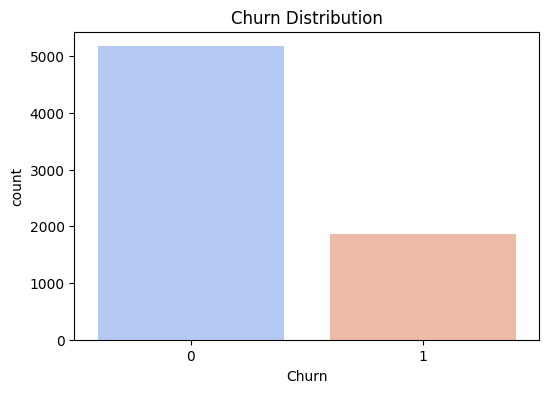

In [62]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", hue="Churn", data=df, palette="coolwarm", legend=False)
plt.title("Churn Distribution")
plt.show()

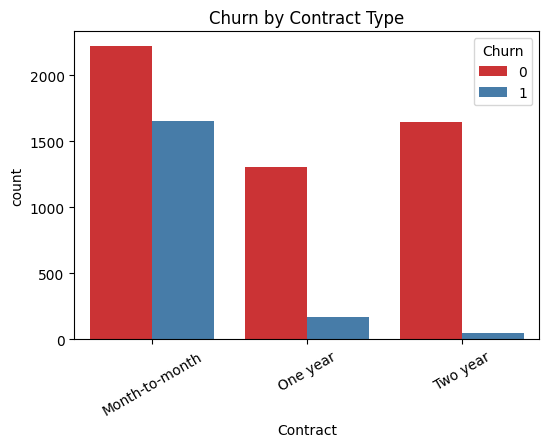

In [63]:
plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=df, palette="Set1")
plt.title("Churn by Contract Type")
plt.xticks(rotation=30)
plt.show()

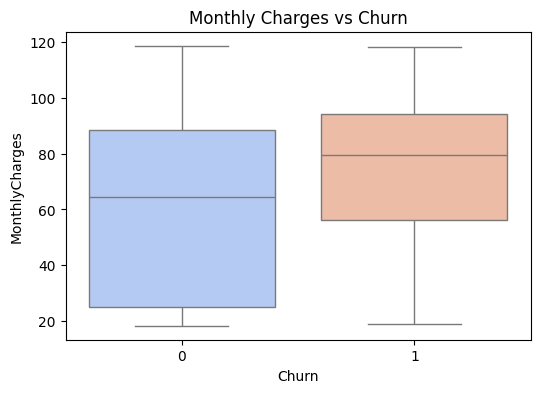

In [64]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="MonthlyCharges", hue="Churn",
            data=df, palette="coolwarm", legend=False)
plt.title("Monthly Charges vs Churn")
plt.show()

### Correlation heatmap

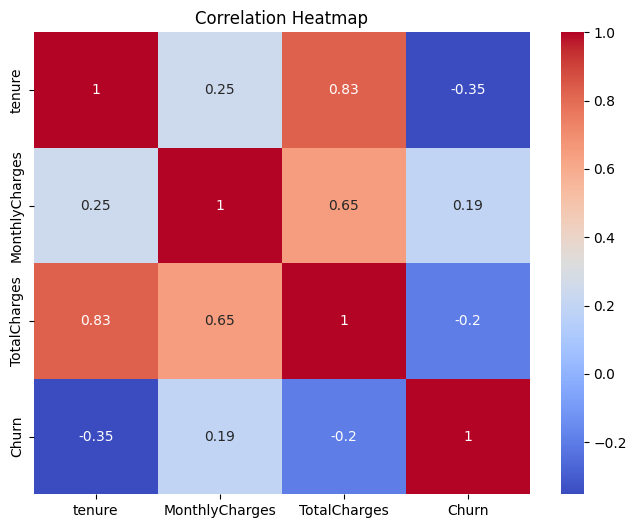

In [65]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["tenure","MonthlyCharges","TotalCharges","Churn"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Logistic Regression

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


In [68]:
print("📊 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

📊 Logistic Regression Results
Accuracy: 0.7842441447835344
ROC-AUC: 0.830713787491281

Confusion Matrix:
 [[991  44]
 [260 114]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      1035
           1       0.72      0.30      0.43       374

    accuracy                           0.78      1409
   macro avg       0.76      0.63      0.65      1409
weighted avg       0.77      0.78      0.75      1409



# Random Forest

In [69]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [70]:
print("\n📊 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


📊 Random Forest Results
Accuracy: 0.8026969481902059
ROC-AUC: 0.8332274148130925


In [71]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Confusion Matrix:
 [[943  92]
 [186 188]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



### Feature importance

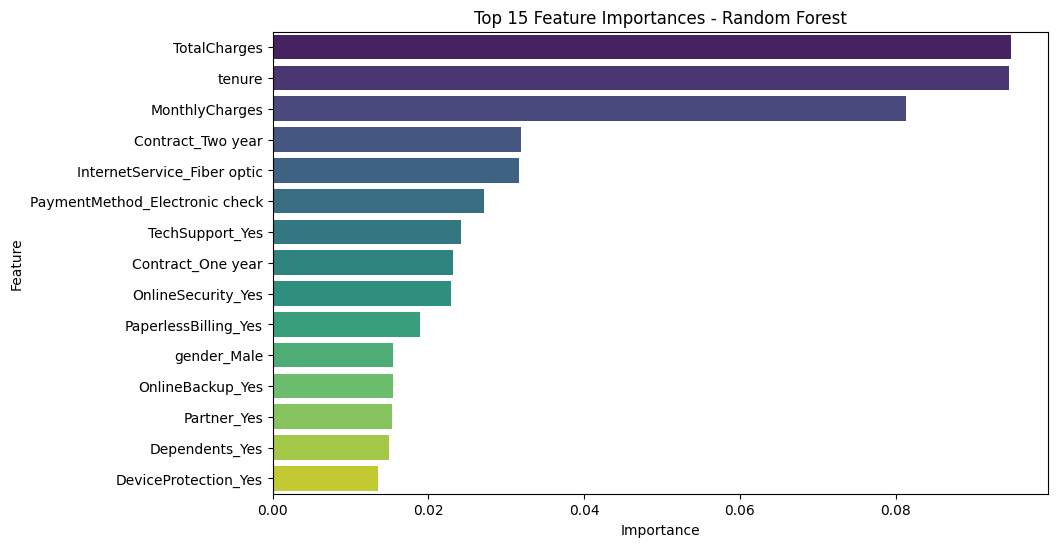

In [74]:
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=feat_imp, palette="viridis", dodge=False, legend=False)
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [ ]:
import joblib

# after training
joblib.dump(log_reg, "logistic_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

# also save your preprocessing pipeline (encoder, scaler)
joblib.dump(preprocessor, "preprocessor.pkl")
